In [13]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import HelperFunctions
import time

In [3]:
# Defines position of xray and ct in space
ctTPos = [
    [1, 0, 0, 19.961],
    [0, 1, 0, 23.7891],
    [0, 0, 1, 164],
    [0, 0, 0, 1]
]

xrayTPos = [
    [-0.2925, -0.0510, -0.9549, 397.8680],
    [-0.9542, 0.0809, 0.2879, 192.7720],
    [0.0625, 0.9954, -0.0723, -107.8180],
    [0, 0, 0, 1]
]

# Source position
xraySPos = [-648.471, 285.483, 117.612]

ctImg = sitk.GetArrayFromImage(sitk.ReadImage("data/ct.nrrd"))
xRayImg = sitk.GetArrayFromImage(sitk.ReadImage("data/xray.nrrd"))

ctData, xRayData = HelperFunctions.prepareImages(ctImg, xRayImg, ctTPos, xrayTPos, xraySPos)

In [4]:
print(ctData["img"].shape)
print(xRayData["img"].shape)

(39, 95, 97)
(446, 446)


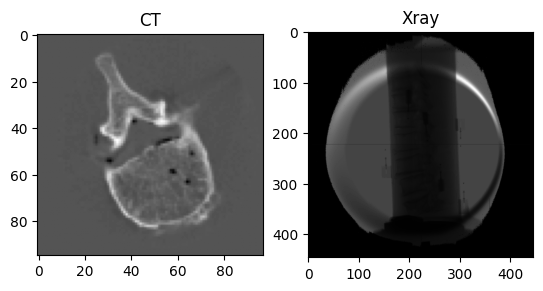

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ctData["img"][19,...], cmap="gray")
ax1.set_title("CT")
ax2.imshow(xRayData["img"], cmap="gray")
ax2.set_title("Xray")
plt.show()

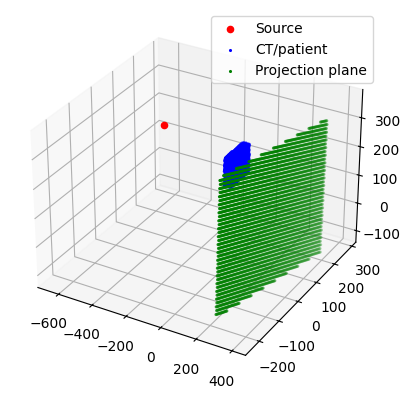

In [6]:
ctXSize, ctYSize, ctZSize = ctData["img"].shape
ctX, ctY, ctZ = np.meshgrid(range(ctXSize), range(ctYSize), range(ctZSize))
ctLocal = np.vstack((ctX.ravel(), ctY.ravel(), ctZ.ravel())).T
ctLocal = HelperFunctions.addHomogCoord(ctLocal)

xrayXsize, xrayYsize = xRayData["img"].shape
xrayX, xrayY = np.meshgrid(range(xrayXsize), range(xrayYsize))
xrayLocal = np.vstack((xrayX.ravel(), xrayY.ravel())).T
xrayLocal = np.hstack((xrayLocal, np.zeros((xrayLocal.shape[0], 1))))
xrayLocal = HelperFunctions.addHomogCoord(xrayLocal)

ctGlobal = np.dot(ctLocal, np.array(ctData["position"]).T)
xrayGlobal = np.dot(xrayLocal, np.array(xRayData["position"]).T)

sourceGlobal = np.array(xRayData["source"]).ravel()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(sourceGlobal[0], sourceGlobal[1], sourceGlobal[2], c="r", label="Source")
ax.scatter(ctGlobal[::50, 0], ctGlobal[::50, 1], ctGlobal[::50, 2], c="b", marker=".", linewidths=0, label="CT/patient")
ax.scatter(xrayGlobal[::50, 0], xrayGlobal[::50, 1], xrayGlobal[::50, 2], c="g", marker=".", linewidths=0, label="Projection plane")
ax.legend()
plt.show()

In [7]:
def mapPointToPlane(iPoints, iXrayPlane):
    """
    Maps points from CT to xray plane based on the source position
    :param iPoints: CT coordinates
    :param iXrayPlane: Plane coordinates
    :return: Projected coordinates
    """
    iPoints = np.array(iPoints)
    if iPoints.ndim == 1:
        iPoints = np.reshape(iPoints, (1, iPoints.size))
    iPoints = iPoints[:,:3]

    source = np.array(xRayData["source"]).reshape(1, 3)
    # Get the unit vector on the plane so you can define the normal on the plane
    p0 = np.dot(iXrayPlane["position"], np.array([0, 0, 0, 1]))
    ex = np.dot(iXrayPlane["position"], np.array([1, 0, 0, 1]))
    ey = np.dot(iXrayPlane["position"], np.array([0, 1, 0, 1]))
    norm = np.cross(ex[:-1] - p0[:-1], ey[:-1] - p0[:-1])
    norm = norm / np.sqrt(np.sum(norm**2))

    # Get the line equation
    alpha = np.dot((p0[:3] - source), norm) / np.dot((iPoints - source), norm)

    oPoints = (iPoints - source) * alpha.reshape((iPoints.shape[0], 1)) + source

    return oPoints


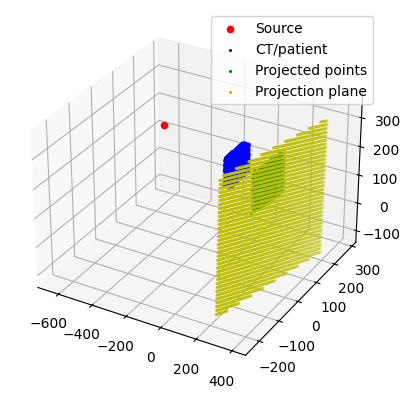

In [8]:
projectedPoints = mapPointToPlane(ctGlobal, xRayData)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(sourceGlobal[0], sourceGlobal[1], sourceGlobal[2], c="r", label="Source")
ax.scatter(ctGlobal[::50, 0], ctGlobal[::50, 1], ctGlobal[::50, 2], c="b", marker=".", linewidths=0, label="CT/patient")
ax.scatter(projectedPoints[::600, 0], projectedPoints[::600, 1], projectedPoints[::600, 2], c="g", marker=".", linewidths=0, label="Projected points")
ax.scatter(xrayGlobal[::50, 0], xrayGlobal[::50, 1], xrayGlobal[::50, 2], c="y", marker=".", linewidths=0, label="Projection plane")
ax.legend()
plt.show()

In [37]:
def project3Dto2D(ctData, xRayData, iStep):
    """
    Projects 3D image to 2D image
    :param ctData: 3D data
    :param xrayData: 2D data
    :param iStep: Step that defines sampling points
    :return: Projected 3D image
    """
    # Get the corner coordinates of CT image
    ctZ, ctY, ctX = ctData["img"].shape
    cornerX, cornerY, cornerZ = np.meshgrid((0, ctX-1), (0, ctY-1), (0, ctZ-1))
    cornerCordinates = np.vstack((cornerX.ravel(), cornerY.ravel(), cornerZ.ravel())).T
    cornerCordinates = HelperFunctions.addHomogCoord(cornerCordinates)

    # Transform to global coordinate frame and add homogenous
    globalCornerCoordinates = np.dot(cornerCordinates, np.array(ctData["position"]).T)
    projectedGlobalCornerCoordinates = mapPointToPlane(globalCornerCoordinates, xRayData)
    projectedGlobalCornerCoordinates = HelperFunctions.addHomogCoord(projectedGlobalCornerCoordinates)

    # Transform back to local coordinate frame of the plane
    projectedLocalCornerCoordinates = np.dot(
        projectedGlobalCornerCoordinates,
        np.linalg.inv(xRayData["position"]).T
    )
    minx = np.floor(np.min(projectedLocalCornerCoordinates[:, 0]))
    maxx = np.ceil(np.max(projectedLocalCornerCoordinates[:, 0]))
    miny = np.floor(np.min(projectedLocalCornerCoordinates[:, 1]))
    maxy = np.ceil(np.max(projectedLocalCornerCoordinates[:, 1]))

    # Check if the values are inside the plane
    planeX, planeY = xRayData["img"].shape
    minx = np.max((0, minx)); minx = int(np.min((planeX, minx)))
    maxx = np.max((0, maxx)); maxx = int(np.min((planeX, maxx)))
    miny = np.max((0, miny)); miny = int(np.min((planeY, miny)))
    maxy = np.max((0, maxy)); maxy = int(np.min((planeY, maxy)))

    # Define coordinates in the plane
    planeCoordinateX, planeCoordinateY = np.meshgrid(range(minx, maxx), range(miny, maxy))
    rectShape = planeCoordinateX.shape

    planeCoordinates = np.vstack((planeCoordinateX.ravel(), planeCoordinateY.ravel())).T
    planeCoordinates = np.hstack((planeCoordinates, np.zeros((planeCoordinates.shape[0], 1))))
    planeCoordinates = HelperFunctions.addHomogCoord(planeCoordinates)
    planeGlobalCoordinates = np.dot(planeCoordinates, np.array(xRayData["position"]).T)

    source = np.array(xRayData["source"]).ravel().reshape(1, 3)

    # Define sampling distance
    d = np.sqrt(np.sum((globalCornerCoordinates[:,:3] - source)**2, axis=1))
    dmin = np.min(d)
    dmax = np.max(d)

    # Define sampling points
    ds = np.arange(dmin, dmax, iStep)
    ds = np.reshape(ds,(1, ds.size))

    vs = planeGlobalCoordinates[:,:3] - source
    vs = vs / np.sqrt(np.sum(vs**2, axis=1)).reshape((vs.shape[0],1))

    Nx1 = (vs.shape[0],1)
    px = source[0,0] + vs[:,0].reshape(Nx1) * ds
    py = source[0,1] + vs[:,1].reshape(Nx1) * ds
    pz = source[0,2] + vs[:,2].reshape(Nx1) * ds

    # Transform coordinates 3d image coordinate frame
    Tmat = np.linalg.inv(ctData["position"])
    pxn = Tmat[0,0]*px + Tmat[0,1]*py + Tmat[0,2]*pz + Tmat[0,3]
    pyn = Tmat[1,0]*px + Tmat[1,1]*py + Tmat[1,2]*pz + Tmat[1,3]
    pzn = Tmat[2,0]*px + Tmat[2,1]*py + Tmat[2,2]*pz + Tmat[2,3]

    # Check if the values are inside the 3d image frame
    idx = np.where((pxn>=0) & (pxn<ctX) & \
                    (pyn>=0) & (pyn<ctY) & \
                    (pzn>=0) & (pzn<ctZ))

    oRayInterp = np.zeros_like(pxn)
    pxn = pxn[idx[0],idx[1]]
    pyn = pyn[idx[0],idx[1]]
    pzn = pzn[idx[0],idx[1]]

    # Interpolate
    oRayInterp_i = interpn((np.arange(ctZ),np.arange(ctY),np.arange(ctX)),
                  ctData['img'].astype('float'),
                  np.dstack((pzn,pyn,pxn)),
                  method='linear', bounds_error=False, fill_value=0)

    oRayInterp[idx[0],idx[1]] = oRayInterp_i

    oRayInterp = np.mean(oRayInterp, axis=1).reshape(rectShape)

    oDRR = np.zeros_like(xRayData['img']).astype('float')
    oMask = np.zeros_like(ctData['img'])

    oDRR[miny:maxy, minx:maxx] = oRayInterp
    oMask[miny:maxy, minx:maxx] = 255

    return oDRR, oMask

Time of calculation: 151.1 ms


Text(0.5, 1.0, 'Superposition')

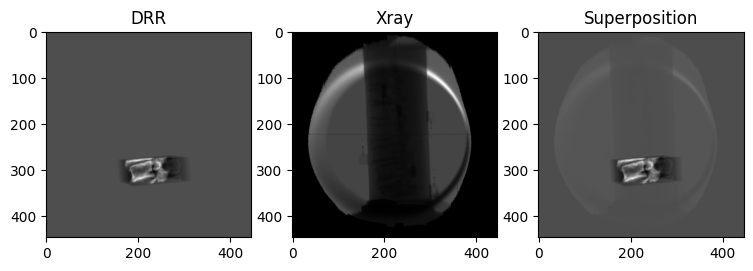

In [38]:
iStep = 1 # Sampling size in mm
ct_temp, Xray_temp = HelperFunctions.prepareImages(ctImg, xRayImg, ctTPos, xrayTPos, xraySPos)
ts = time.time()
oDRR, oDRRMask = project3Dto2D(ct_temp, Xray_temp, iStep)
print('Time of calculation: {:.1f} ms'.format(1000.0*(time.time()-ts)))

f, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(oDRR, cmap='gray')
ax[0].set_title('DRR')
ax[1].imshow(Xray_temp['img'], cmap='gray')
ax[1].set_title('Xray')
ax[2].imshow(
    2*HelperFunctions.normalizeImage(oDRR) +
    HelperFunctions.normalizeImage(Xray_temp['img']),
    cmap='gray')
ax[2].set_title('Superposition')